In [390]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer
%matplotlib inline

## Read in data and create time features

In [391]:
project_5526 = pd.read_csv('../capstone_data/Azimuth/project_5526.csv')
project_5526.dropna(inplace=True)
project_5526.info()

project_5526['t'] = pd.to_datetime(project_5526['t'], format='%Y-%m-%d %H:%M:%S')
project_5526.sort_values('t',inplace=True)
project_5526 = project_5526.set_index('t')
project_5526['year'] = project_5526.index.year
project_5526['month'] = project_5526.index.month
project_5526['day'] = project_5526.index.day
project_5526['dayofweek'] = project_5526.index.dayofweek
project_5526['hour'] = project_5526.index.hour

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154385 entries, 1 to 154389
Data columns (total 9 columns):
project_id    154385 non-null object
t             154385 non-null object
relay         154385 non-null float64
load_v1rms    154385 non-null float64
load_v2rms    154385 non-null float64
load_v3rms    154385 non-null float64
load_i1rms    154385 non-null float64
load_i2rms    154385 non-null float64
laod_i3rms    154385 non-null float64
dtypes: float64(7), object(2)
memory usage: 11.8+ MB


## Reduce Relay signal to 0s and 1s

In [392]:
project_5526['relay_est'] = project_5526['relay'].apply(lambda x: 0 if x == 1.0 else 1)

In [393]:
project_5526['relay_est'].value_counts()

0    130385
1     24000
Name: relay_est, dtype: int64

## Identify records where time continuity is broken

In [394]:
# tagging periods where the proceeding datapoint is not 5 minutes
time = pd.Series(project_5526.index)
time2 = pd.Series(project_5526.index).shift(1)
ser = pd.Series(time - time2)
ser = ser.apply(lambda x: None if x!=pd.to_timedelta('0 days 00:05:00')else 1)
project_5526['t_diff']= pd.Series(ser).values

## Plots for examining data

In [395]:
def plot_all_data(df,columns):
    years = df['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = df[(df['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)

    fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, 5*len(y_m_combinations)))
    for ax, c in zip(axs,y_m_combinations):
        temp = df[(df['year'] == c[0]) & (df['month'] == c[1])]
        for col in columns:
            ax.plot(temp.index, temp[col]/df[col].max())
        ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [396]:
def plot_time_frame(df,start,end,columns):
    '''
    Plot the timeseries for a given period of time
    PARAMETERS
    ------------
    df : Pandas DataFrame with DatetimeIndex
    start: string in format 'YYYY-MM-DD HH:MM:SS'
    end: string in format 'YYYY-MM-DD HH:MM:SS'
    columns: list of column names
    RETURNS
    -------
    None: plots the graphs
    '''
    temp = df.loc[(df.index>=start)&(df.index<end)]
    years = temp['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = temp[(temp['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)
    
    if len(y_m_combinations) ==1:
        temp2 = temp[(temp['year'] == y_m_combinations[0][0]) & (temp['month'] == y_m_combinations[0][1])]
        plt.figure(figsize=(14,4))
        for col in columns:
            plt.plot(temp2.index, temp2[col]/df[col].max())
        plt.title('timeseries for {}, {}'.format(y_m_combinations[0][0],y_m_combinations[0][0]))
        
    else:
        fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, len(y_m_combinations)*4))
        for ax, c in zip(axs,y_m_combinations):
            temp2 = temp[(temp['year'] == c[0]) & (temp['month'] == c[1])]
            for col in columns:
                ax.plot(temp2.index, temp2[col]/df[col].max())
            ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

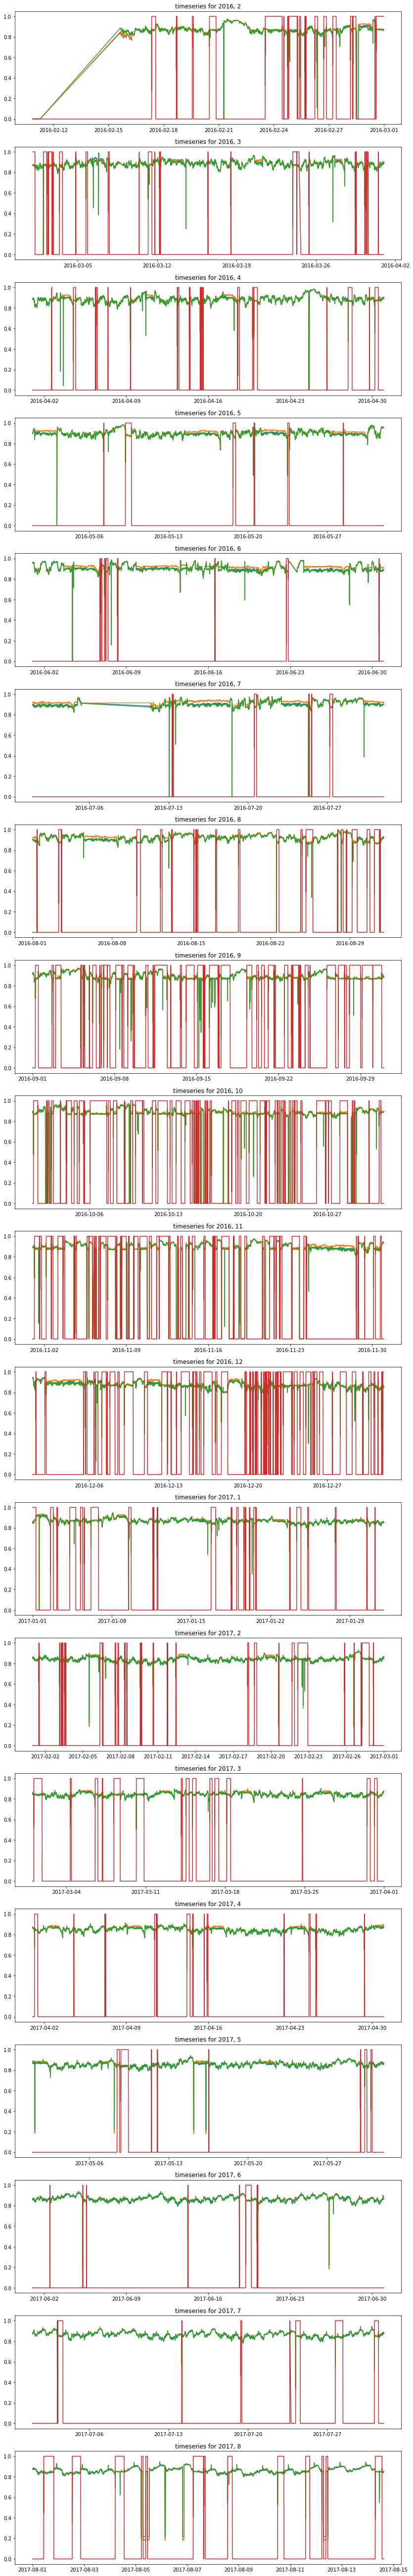

In [397]:
plot_all_data(project_5526, columns=['load_v1rms','load_v2rms','load_v3rms','relay_est'])

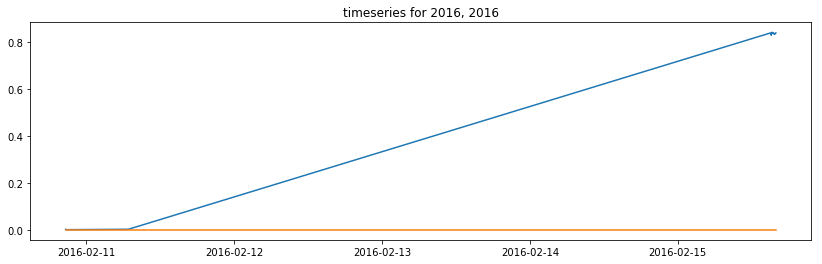

In [398]:
plot_time_frame(project_5526,'2016-02-10 00:00:00','2016-02-15 16:00:00',columns=['load_v1rms','relay_est'])

In [399]:
bad_data = [('2016-02-10 00:00:00','2016-02-15 16:00:00')]

## Function to label and remove bad data periods

In [400]:
def label_bad_data(df, dates):
    df['data_issue']=0
    for d in dates:
        df.loc[(df.index>=d[0])&(df.index<d[1]),'data_issue'] = 1
    return df

In [401]:
df = label_bad_data(project_5526, bad_data)
df.data_issue.value_counts()

0    154371
1        14
Name: data_issue, dtype: int64

In [402]:
def remove_time_period(df,start, end):
    new_df = df.loc[~((df.index>=start)&(df.index<end))]
    return new_df

## Write data to csv

In [403]:
df.to_csv('../capstone_data/Azimuth/clean/project_5526_clean.csv', index=True)

## Function to create time shifted features

In [340]:
def shift_features(df, features, deltas):
    shifted_dfs = [df]
    for d in deltas:
        shifted = df[features].shift(d)
        col_names = []
        for f in features:
            name = '{}-{}'.format(f,d)
            col_names.append(name)
        
        shifted.columns = col_names
        time_diff = (pd.Series(df.index) - pd.Series(df.index).shift(d))
        time_string = '0 days 00:0{}:00'.format(d*5)
        time_diff = time_diff.apply(lambda x: None if x!= pd.to_timedelta(time_string) else 1)
        time_diff_col_name = 't_diff-{}'.format(d)
        shifted[time_diff_col_name] = time_diff.values
        
        shifted_dfs.append(shifted)
    new_df = pd.concat(shifted_dfs,axis=1)
    return new_df

In [362]:
df = shift_features(project_5526, ['load_v1rms','load_v2rms','load_v3rms',
                                   'load_i1rms','load_i2rms','laod_i3rms',
                                    'relay_est'],[1,2,3,4])

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154385 entries, 2016-02-10 20:40:00 to 2017-08-14 15:15:00
Data columns (total 48 columns):
project_id      154385 non-null object
relay           154385 non-null float64
load_v1rms      154385 non-null float64
load_v2rms      154385 non-null float64
load_v3rms      154385 non-null float64
load_i1rms      154385 non-null float64
load_i2rms      154385 non-null float64
laod_i3rms      154385 non-null float64
year            154385 non-null int64
month           154385 non-null int64
day             154385 non-null int64
dayofweek       154385 non-null int64
hour            154385 non-null int64
relay_est       154385 non-null int64
t_diff          154344 non-null float64
data_issue      154385 non-null int64
load_v1rms-1    154384 non-null float64
load_v2rms-1    154384 non-null float64
load_v3rms-1    154384 non-null float64
load_i1rms-1    154384 non-null float64
load_i2rms-1    154384 non-null float64
laod_i3rms-1    154384 non-nul

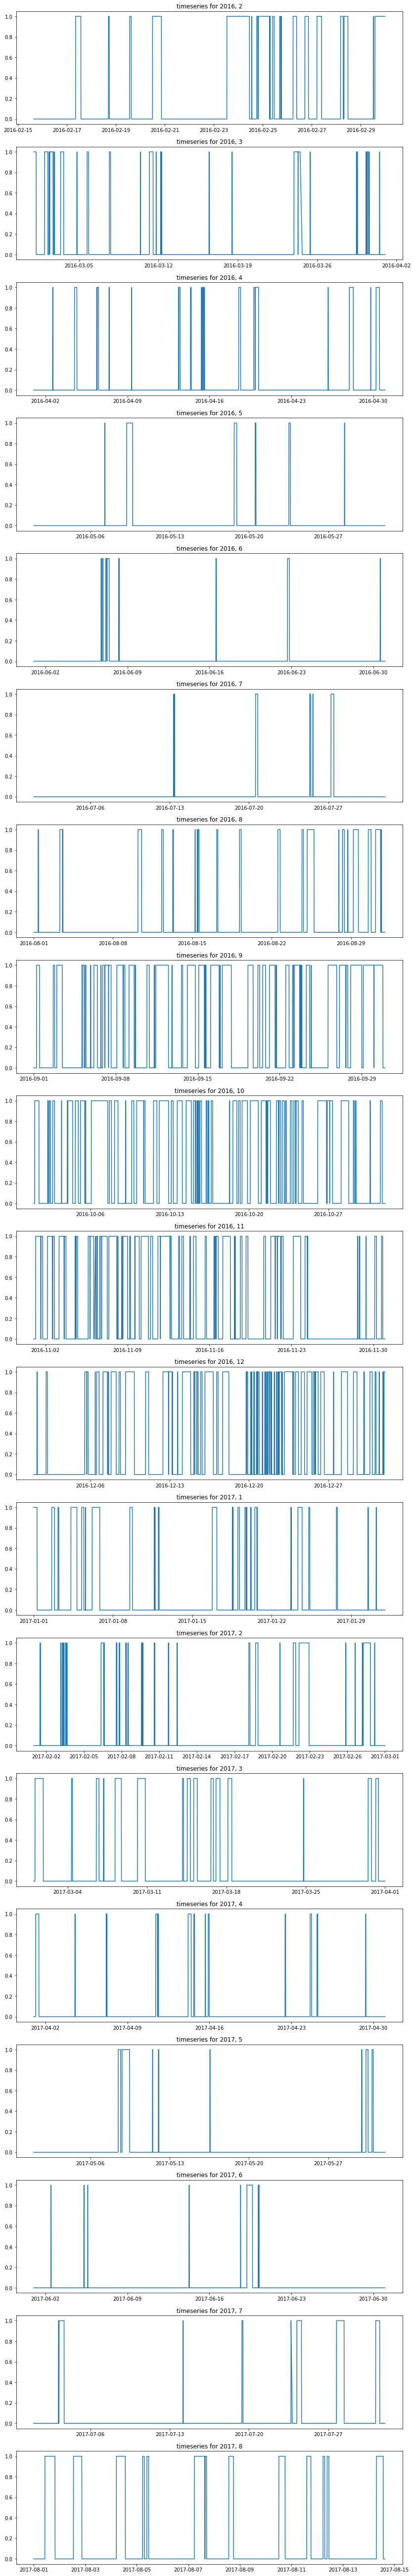

In [366]:
plot_all_data(df,['relay_est'])

### Dropping data points where the preceeding time periods are incorrect

In [367]:
df.dropna(inplace=True)
df.shape

(154226, 48)

### Getting dummies for categorical

In [368]:
df = pd.get_dummies(df, columns =['month'])

In [369]:
df = pd.get_dummies(df, columns =['dayofweek'])

### Removing outage points which are in an outage

In [370]:
df2 = df[~((df['relay_est']==1)&(df['relay_est-1']==1))]
df2.shape

(130689, 65)

In [371]:
df2.groupby(['relay_est','relay_est-1'])['relay'].count()

relay_est  relay_est-1
0          0.0            129789
           1.0               449
1          0.0               451
Name: relay, dtype: int64

In [372]:
df2.groupby('relay_est')['load_v1rms-1','load_v2rms-1','load_v3rms-1','load_v1rms-1','load_v2rms-2','load_v3rms-3'].mean()

,load_v1rms-1,load_v2rms-1,load_v3rms-1,load_v1rms-1,load_v2rms-2,load_v3rms-3
relay_est,,,,,,
0,235.734494,234.833996,226.303382,235.734494,234.946631,226.492105
1,172.585307,171.533361,166.061157,172.585307,198.691215,198.578923


## Bringing in weather

In [350]:
weather_16 = pd.read_csv('merra_data/accra_2016/weather_data_Accra_2016.csv')
weather_17 = pd.read_csv('merra_data/accra_2017/weather_data_Accra_2017.csv')

In [351]:
weather_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35136 entries, 0 to 35135
Data columns (total 23 columns):
lat                35136 non-null float64
lon                35136 non-null float64
cumulated hours    35136 non-null int64
timestamp          35136 non-null object
v1                 35136 non-null float64
v2                 35136 non-null float64
v3                 35136 non-null float64
d1                 35136 non-null float64
d2                 35136 non-null float64
d3                 35136 non-null float64
z0                 35136 non-null float64
irr_dir            35136 non-null float64
irr_glo            35136 non-null float64
T                  35136 non-null float64
rho                35136 non-null float64
p                  35136 non-null float64
liq_precip         35136 non-null float64
vap_precip         35136 non-null float64
cloud_1            35136 non-null float64
cloud-2            35136 non-null float64
h1                 35136 non-null int64
h2            

In [352]:
weather = weather_16.append(weather_17, ignore_index=True)

In [353]:
weather.head()

,lat,lon,cumulated hours,timestamp,v1,v2,v3,d1,d2,d3,...,T,rho,p,liq_precip,vap_precip,cloud_1,cloud-2,h1,h2,h3
0,5.5,-0.625,0,2016-01-01T00:00:00Z,1.86,2.70,3.90,48.11,48.57,49.05,...,298.285706,1.158288,100394.710938,0.037537,40.992363,0.251709,16.601562,3,11,51
1,5.5,-0.625,1,2016-01-01T01:00:00Z,1.83,2.63,3.81,55.08,57.30,59.08,...,298.179962,1.158091,100348.164062,0.052750,41.744568,0.288452,18.148438,3,11,51
2,5.5,-0.625,2,2016-01-01T02:00:00Z,1.82,2.64,3.89,65.39,69.33,72.17,...,298.065552,1.158167,100310.992188,0.066772,42.636341,0.295532,20.828125,3,11,51
3,5.5,-0.625,3,2016-01-01T03:00:00Z,1.81,2.61,3.90,74.87,79.65,82.80,...,297.906677,1.159256,100306.773438,0.090759,43.740402,0.315063,35.000000,3,11,51
4,5.5,-0.625,4,2016-01-01T04:00:00Z,1.74,2.49,3.78,82.33,87.24,90.62,...,297.713470,1.161039,100332.796875,0.112610,44.928085,0.347046,62.640625,3,11,51


In [354]:
weather['timestamp'] = pd.to_datetime(weather['timestamp'], format='%Y-%m-%d %H:%M:%S')
weather.sort_values('timestamp',inplace=True)
weather = weather.set_index('timestamp')

In [355]:
weather['year'] = weather.index.year
weather['month'] = weather.index.month
weather['day'] = weather.index.day
weather['dayofweek'] = weather.index.dayofweek
weather['hour'] = weather.index.hour

In [356]:
# weather = weather[weather['lat']==5.5]
# weather = weather[weather['lon']==-6.25000000e-01]
# weather['lon'].unique()
weather = pd.DataFrame(weather.groupby(['year','month','day','hour']).mean()).reset_index()
weather.head()

,year,month,day,hour,lat,lon,cumulated hours,v1,v2,v3,...,rho,p,liq_precip,vap_precip,cloud_1,cloud-2,h1,h2,h3,dayofweek
0,2016,1,1,0,5.75,-0.3125,0.0,1.5275,2.2650,3.4450,...,1.155755,100102.710938,0.037651,40.492363,0.273743,15.788086,3.25,11.25,51.25,4.0
1,2016,1,1,1,5.75,-0.3125,1.0,1.5000,2.2375,3.3750,...,1.155466,100050.164062,0.049858,40.935974,0.276367,16.306641,3.25,11.25,51.25,4.0
2,2016,1,1,2,5.75,-0.3125,2.0,1.5300,2.3100,3.5450,...,1.155558,100008.992188,0.059784,41.366810,0.277679,17.711914,3.25,11.25,51.25,4.0
3,2016,1,1,3,5.75,-0.3125,3.0,1.5775,2.3675,3.7325,...,1.156692,100004.773438,0.075233,41.877121,0.278503,23.195312,3.25,11.25,51.25,4.0
4,2016,1,1,4,5.75,-0.3125,4.0,1.5675,2.3325,3.7325,...,1.158521,100032.796875,0.085686,42.303085,0.292221,39.226562,3.00,11.00,51.00,4.0


In [357]:
df2['year'] = df2.index.year
df2['month'] = df2.index.month
df2['index'] = df2.index
df3 = df2.merge(weather,how='right',on=['year','month','day','hour']).set_index('index')

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [358]:
# df3.info()
df3.dropna(inplace=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127509 entries, 2016-02-15 15:25:00 to 2017-07-31 23:55:00
Data columns (total 89 columns):
project_id         127509 non-null object
relay              127509 non-null float64
load_v1rms         127509 non-null float64
load_v2rms         127509 non-null float64
load_v3rms         127509 non-null float64
load_i1rms         127509 non-null float64
load_i2rms         127509 non-null float64
laod_i3rms         127509 non-null float64
year               127509 non-null int64
day                127509 non-null int64
hour               127509 non-null int64
relay_est          127509 non-null float64
t_diff             127509 non-null float64
data_issue         127509 non-null float64
load_v1rms-1       127509 non-null float64
load_v2rms-1       127509 non-null float64
load_v3rms-1       127509 non-null float64
load_i1rms-1       127509 non-null float64
load_i2rms-1       127509 non-null float64
laod_i3rms-1       127509 non-null float64
re

In [302]:
y = df3['relay_est']
X = df3.drop([u'project_id', u'relay', u'load_v1rms', u'load_v2rms', u'load_v3rms',
       u'load_i1rms', u'load_i2rms', u'laod_i3rms', u'year', u'day',
        u'relay_est', u't_diff',u't_diff-1',u't_diff-2',u't_diff-3','t_diff-4',
        'lat','lon','cumulated hours','z0','h1','h2','h3','dayofweek'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127509 entries, 2016-02-15 15:25:00 to 2017-07-31 23:55:00
Data columns (total 65 columns):
hour            127509 non-null int64
data_issue      127509 non-null float64
load_v1rms-1    127509 non-null float64
load_v2rms-1    127509 non-null float64
load_v3rms-1    127509 non-null float64
load_i1rms-1    127509 non-null float64
load_i2rms-1    127509 non-null float64
laod_i3rms-1    127509 non-null float64
relay_est-1     127509 non-null float64
load_v1rms-2    127509 non-null float64
load_v2rms-2    127509 non-null float64
load_v3rms-2    127509 non-null float64
load_i1rms-2    127509 non-null float64
load_i2rms-2    127509 non-null float64
laod_i3rms-2    127509 non-null float64
relay_est-2     127509 non-null float64
load_v1rms-3    127509 non-null float64
load_v2rms-3    127509 non-null float64
load_v3rms-3    127509 non-null float64
load_i1rms-3    127509 non-null float64
load_i2rms-3    127509 non-null float64
laod_i3rms-3    1

In [303]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=3)
tree_range = [20,40,60,80,100]
scores = []
for n in tree_range:
    rfc = RandomForestClassifier(max_features=10, n_estimators =n, oob_score=True)
    model = rfc.fit(X_train, y_train)
    scores.append(model.oob_score_)
    

In [304]:
scores

[0.99691522623417095,
 0.99696751053528665,
 0.99705116541707184,
 0.99707207913751816,
 0.99718710459997284]

In [305]:
model.score(X_train, y_train)

1.0

In [306]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [307]:
print 'For the train set'
print 'recall {}:'.format(recall_score(y_train, y_pred_train))
print 'precision {}:'.format(precision_score(y_train, y_pred_train))
print 'f1 {}:'.format(f1_score(y_train, y_pred_train))

For the train set
recall 1.0:
precision 1.0:
f1 1.0:


In [308]:
print 'For the test set'
print 'recall {}:'.format(recall_score(y_test, y_pred_test))
print 'precision {}:'.format(precision_score(y_test, y_pred_test))
print 'f1 {}:'.format(f1_score(y_test, y_pred_test))

For the test set
recall 0.225490196078:
precision 0.793103448276:
f1 0.351145038168:


In [309]:
zip(model.feature_importances_,X.columns)

[(0.009821506621667692, 'hour'),
 (0.0, 'data_issue'),
 (0.06305071151450764, 'load_v1rms-1'),
 (0.0590275438075583, 'load_v2rms-1'),
 (0.057743864977004671, 'load_v3rms-1'),
 (0.029483130799817629, 'load_i1rms-1'),
 (0.026816625403239452, 'load_i2rms-1'),
 (0.028349083522994156, 'laod_i3rms-1'),
 (0.0023737122093462847, 'relay_est-1'),
 (0.028008200586912148, 'load_v1rms-2'),
 (0.025437593933921702, 'load_v2rms-2'),
 (0.026706698619017116, 'load_v3rms-2'),
 (0.028205949705809457, 'load_i1rms-2'),
 (0.02986535171839352, 'load_i2rms-2'),
 (0.025921398510975906, 'laod_i3rms-2'),
 (0.0032815752567721857, 'relay_est-2'),
 (0.02228756368252233, 'load_v1rms-3'),
 (0.021807189937440158, 'load_v2rms-3'),
 (0.02148552784614885, 'load_v3rms-3'),
 (0.032215529799061622, 'load_i1rms-3'),
 (0.027198093464635351, 'load_i2rms-3'),
 (0.032105967909870775, 'laod_i3rms-3'),
 (0.0023091151607171757, 'relay_est-3'),
 (0.024384883333383511, 'load_v1rms-4'),
 (0.019640373773632126, 'load_v2rms-4'),
 (0.0206

In [310]:
params = {'n_estimators':[20,60], 'max_features':['sqrt',5], 'max_depth':[20,50]}
scorer = make_scorer(recall_score)
gs_rfc = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid=params, scoring=scorer, n_jobs=-1,cv=5)
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [20, 60], 'max_features': ['sqrt', 5], 'max_depth': [20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=0)

In [311]:
model = gs_rfc.best_estimator_
gs_rfc.best_score_

0.23191476384631743

In [312]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print 'For the train set'
print 'recall {}:'.format(recall_score(y_train, y_pred_train))
print 'precision {}:'.format(precision_score(y_train, y_pred_train))
print 'f1 {}:'.format(f1_score(y_train, y_pred_train))
print 'For the test set'
print 'recall {}:'.format(recall_score(y_test, y_pred_test))
print 'precision {}:'.format(precision_score(y_test, y_pred_test))
print 'f1 {}:'.format(f1_score(y_test, y_pred_test))

For the train set
recall 0.928571428571:
precision 1.0:
f1 0.962962962963:
For the test set
recall 0.235294117647:
precision 0.8:
f1 0.363636363636:
